## Library imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from chromatography import *
from torch import optim, tensor
import matplotlib.pyplot as plt
%matplotlib inline

## Dataset Import

In [3]:
alist = pd.read_csv('../data/GilarSample.csv')

## Useful functions definition

In [4]:
def reinforce(
        exp, 
        policy, 
        delta_taus, 
        num_episodes = 1000, 
        batch_size = 10, 
        lr = 1., 
        optim = optim.Adam,
        print_every = 100,
        lr_decay = None,
        weights = [1., 1.],
        baseline = 0.
    ):

    losses = []
    loss = 0
    
    for n in range(num_episodes):
        # learning rate decay
        if lr_decay:
            lr = lr_decay(lr, n, num_episodes)            
        
        # Optimizer
        optimizer = optim(policy.parameters(), lr=lr)
        
        # compute distribution parameters (Normal)
        policy.forward()
        # Sample some values from the actions distributions
        programs = policy.sample(batch_size)
        
        # Fit the sampled data to the constraint [0,1]
        constr_programs = programs.clone()
        constr_programs[constr_programs > 1] = 1
        constr_programs[constr_programs < 0] = 0
        
        J = 0
        for i in range(batch_size):
            exp.reset()            
            exp.run_all(constr_programs[i].data.numpy(), delta_taus)
            error = exp.loss(weights)
            loss += error
            J += (error - baseline) * log_prob(programs[i], policy.mu, policy.sigma)
            
        if (n + 1) % print_every == 0:
            losses.append(loss/(batch_size * print_every))
            print(f"Loss: {losses[-1]}, epoch: {n+1}/{num_episodes}")
            loss = 0
        J /= batch_size  
        optimizer.zero_grad()
        
        # Calculate gradients
        J.backward()
        
        # Apply gradients
        optimizer.step()
        
    return losses

In [5]:
def lr_decay(lr, n, n_episodes):
    if (n + 1) % 100 == 0:
        return lr - 0.001
    return lr

In [27]:
exp = ExperimentAnalytes(k0 = alist.k0.values, S = alist.S.values, h=0.001, grad='iso', run_time=None)
pol = Policy(4)

In [28]:
losses = reinforce(
        exp, 
        pol, 
        [.25, .25, .25, .25], 
        num_episodes=1000, 
        batch_size=10, 
        lr=.11, 
        optim=optim.Adam,
        print_every=100,
        lr_decay=lr_decay,
        baseline=0.15
    )

Loss: 0.70698293863117, epoch: 100/1000
Loss: 0.5482123333240406, epoch: 200/1000
Loss: 0.48546484387642597, epoch: 300/1000
Loss: 0.35576277762162306, epoch: 400/1000
Loss: 0.35402994916731206, epoch: 500/1000
Loss: 0.35257621677341855, epoch: 600/1000
Loss: 0.29502055205247185, epoch: 700/1000
Loss: 0.15128831276521845, epoch: 800/1000
Loss: 0.12585776328099843, epoch: 900/1000
Loss: 0.15114462690186498, epoch: 1000/1000


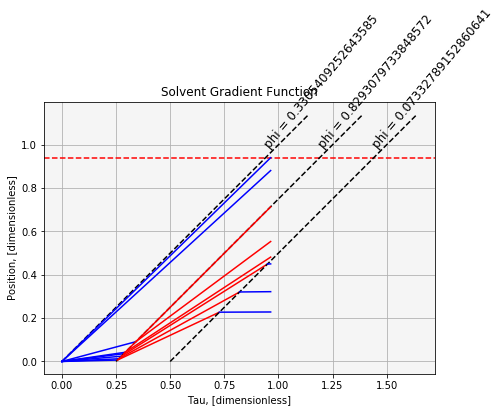

In [29]:
exp.print_analytes(rc=(7, 5))

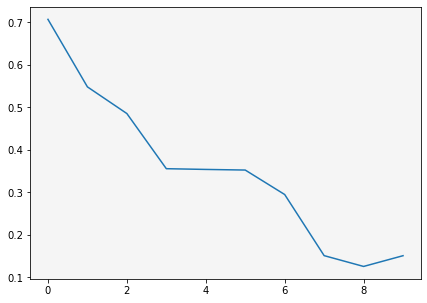

In [30]:
plt.plot(losses)